# Goal

The following notebook shows use of simple sine signal generation practice from [BasicGenerator.py](BasicGenerator.py)

After that [SincPsd.py](SincPsd.py) is used to process the signal and [SignalPsdPlotter.py](SignalPsdPlotter.py) is used to plot it.


# Signal generation

## Sine generation

Of the two main frequency components of HRV, namely low-frequency (LF, 0.04-0.15 Hz) and high-frequency (HF, 0.15-0.4 Hz) components.

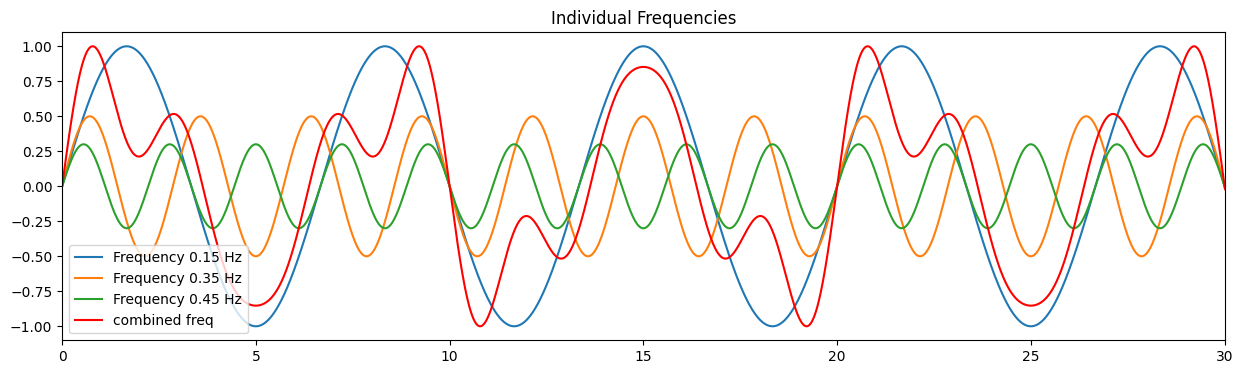

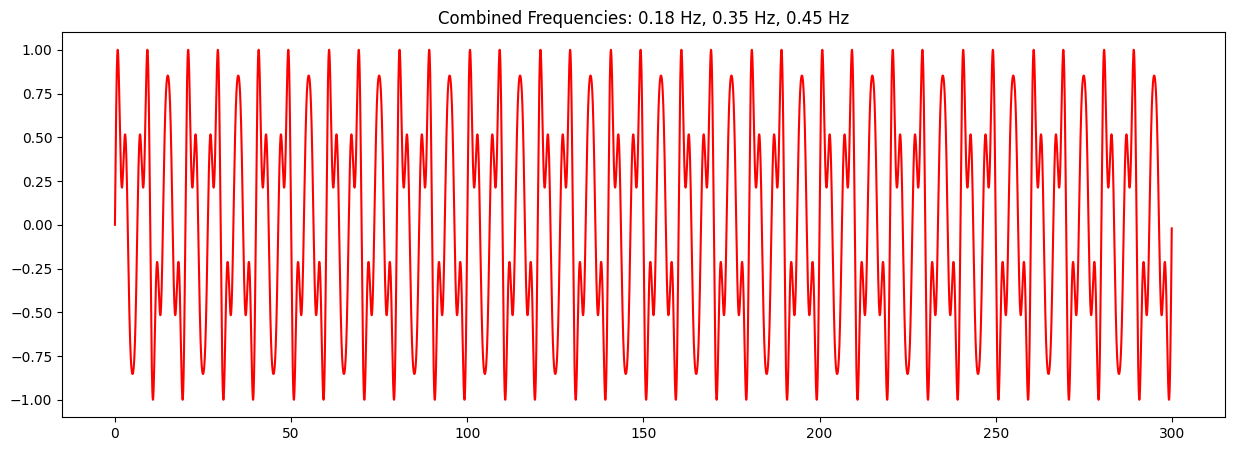

In [16]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib

import BasicGenerator


frequencies = [0.15, 0.35, 0.45]
magnitudes = [1, 0.5, 0.3]

signal = BasicGenerator.generate_combined_sines(frequencies, magnitudes)

plt.figure(figsize=(15, 4))
plt.xlim(0, 30)

# Combine frequencies and plot the resulting signal
for (freq, mag) in zip(frequencies, magnitudes):
    plt.plot(BasicGenerator.create_single_frequency(freq, mag), label=f'Frequency {freq} Hz')
plt.plot(signal,label='combined freq', color='r')
plt.legend()
plt.title('Individual Frequencies')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(signal, color='r')
plt.title('Combined Frequencies: 0.18 Hz, 0.35 Hz, 0.45 Hz')
plt.show()

Note that the very act of using a digital system introduces high frequency components in fft
My own class to simplify plotting singal and its psd

# Sinc Interpolation Quality proof
Sinc (Whitetaker-Shanon interpolation) can be found in [sinc_interpolation.py](sinc_interpolation.py)
Also a plotting tool for it at 

Altough, Sinc (whitetaker-Shanon) interpolation distorsts the signal in the time domain. Normalized PSD is identical to the orginal signal.

In [17]:
import SincPsd

signal=signal
original_psd = SincPsd.signal_to_PSD(signal, 100)

indices = np.linspace(0, len(signal) - 1, 400, dtype=int)
sampled_signal = signal.iloc[indices]
psd_sampled = SincPsd.signal_to_PSD(sampled_signal,400/300)

random_sample = signal.sample(n=600, random_state=1).sort_index()
psd_random = SincPsd.signal_to_PSD(random_sample,2)
            
sinc_signal = SincPsd.sinc_interpolate(random_sample)
sinc_psd = SincPsd.sinc_and_psd(random_sample)


# Plot signals
from SignalPsdPlotter import SignalPsdPlotter

plotter = SignalPsdPlotter()

plotter.plot_signal_and_psd(signal, original_psd, 'Original Signal', 'green')
plotter.plot_signal_and_psd(sinc_signal, sinc_psd, 'Sinc Interpolation', 'black')
plotter.plot_signal_and_psd(sampled_signal, psd_sampled, 'Constant Sampled Signal', 'blue')
plotter.plot_signal_and_psd(random_sample, psd_random, 'Random Sampled Signal', 'red')

plotter.show()

# HRV sine synthesis


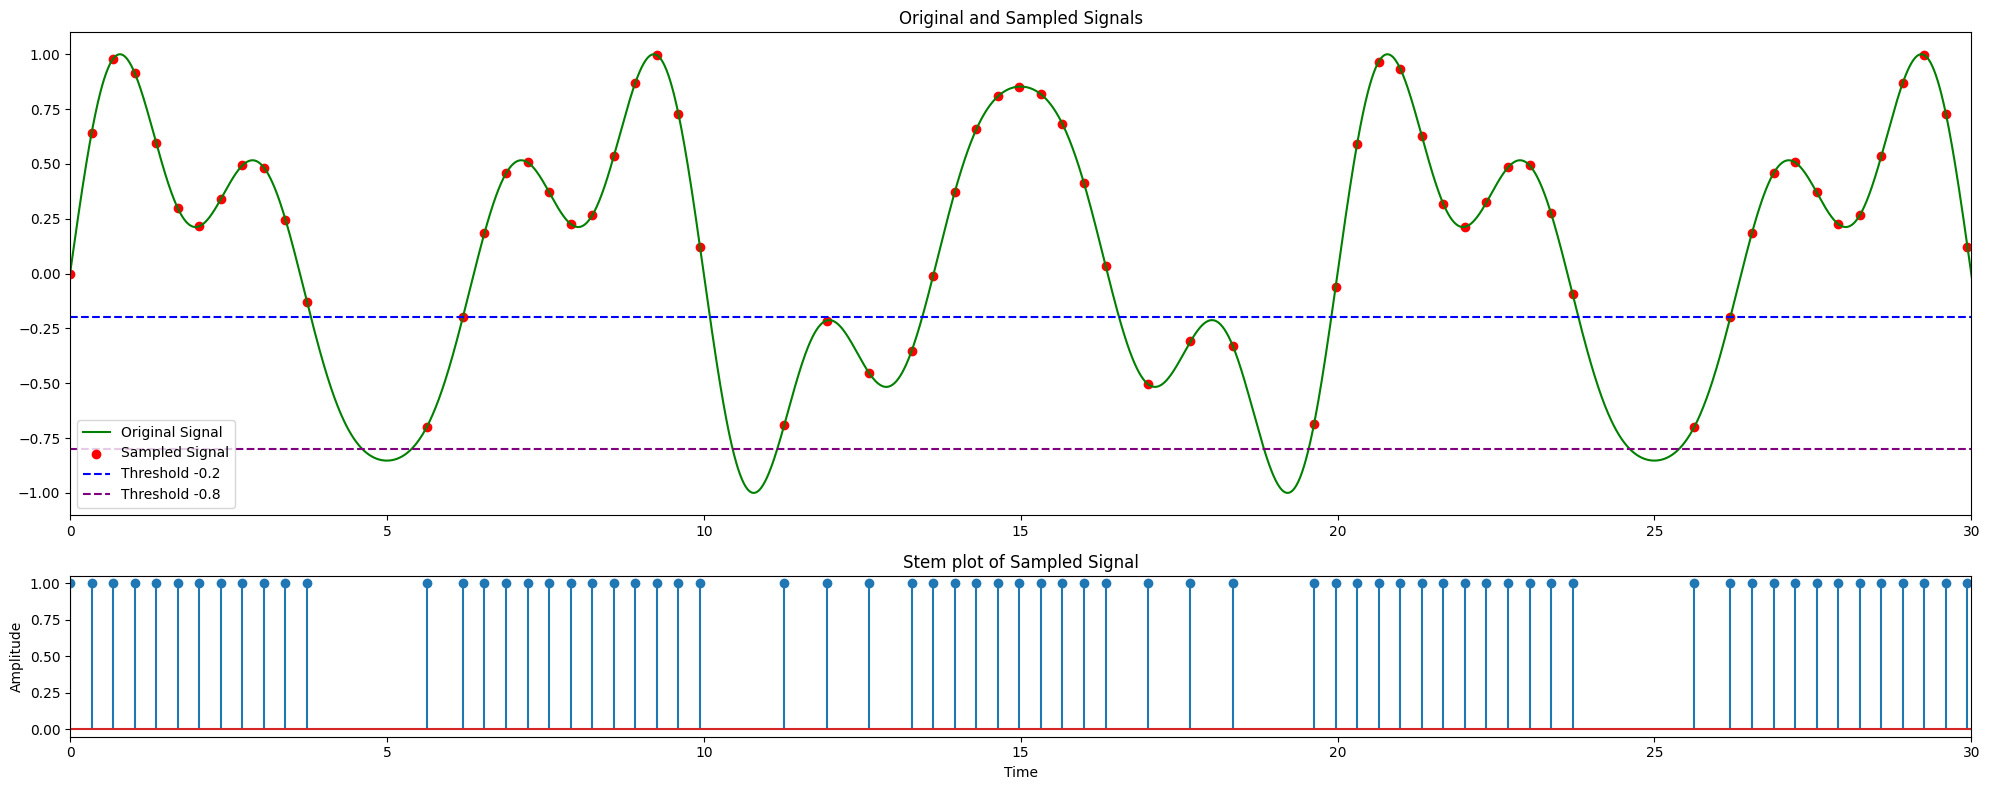

In [18]:
sampled_signal = BasicGenerator.generate_sin_HRV(signal)

fig, axs = plt.subplots(2, 1, figsize=(20, 8), gridspec_kw={'height_ratios': [3, 1]})

# Plot the original and sampled signals
axs[0].plot(signal, label='Original Signal', color='green')
axs[0].scatter(sampled_signal.index, sampled_signal.values, color='red', label='Sampled Signal')
axs[0].set_xlim(0, 30)
axs[0].legend()
axs[0].set_title('Original and Sampled Signals')

# Plot the stem plot of the sampled signal
axs[1].stem(sampled_signal.index, np.ones_like(sampled_signal.values))
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Stem plot of Sampled Signal')
axs[1].set_xlim(0, 30)

# Draw horizontal lines at -0.2 and -0.8
axs[0].axhline(y=-0.2, color='blue', linestyle='--', label='Threshold -0.2')
axs[0].axhline(y=-0.8, color='purple', linestyle='--', label='Threshold -0.8')
axs[0].legend()

plt.tight_layout()
plt.show()

# windowing


In [19]:
original_psd = SincPsd.signal_to_PSD(signal, 100)
sinc_signal = SincPsd.sinc_interpolate(random_sample)
sinc_psd = SincPsd.sinc_and_psd(random_sample)
HRV, resampled_HRV, resampled_psd = sinc_signal, sinc_signal, sinc_psd

simulation_test = SignalPsdPlotter()
simulation_test.plot_signal_and_psd(signal, original_psd, 'original', 'green')
simulation_test.plot_signal_and_psd(resampled_HRV, resampled_psd, 'resampled', 'black')


windowed_signal = resampled_HRV
windowed_signal = SincPsd.window(windowed_signal, 1/16, 'sin')

HRV_sampling_freq = 1 / resampled_HRV.index.diff()
windowed_psd = SincPsd.signal_to_PSD(windowed_signal, HRV_sampling_freq)
windowed_psd = SincPsd.signal_to_PSD(windowed_signal, HRV_sampling_freq)

simulation_test.plot_signal_and_psd(windowed_signal, windowed_psd, 'windowed', 'red')

simulation_test.show()

{window_type} window applied over:
left: index 0 to 17
right: index 582 to 600


# Min max approach
Following attempts of achieving the same using local maxima and minima.
It is quite useless, since the spectra looks nothing like it should.


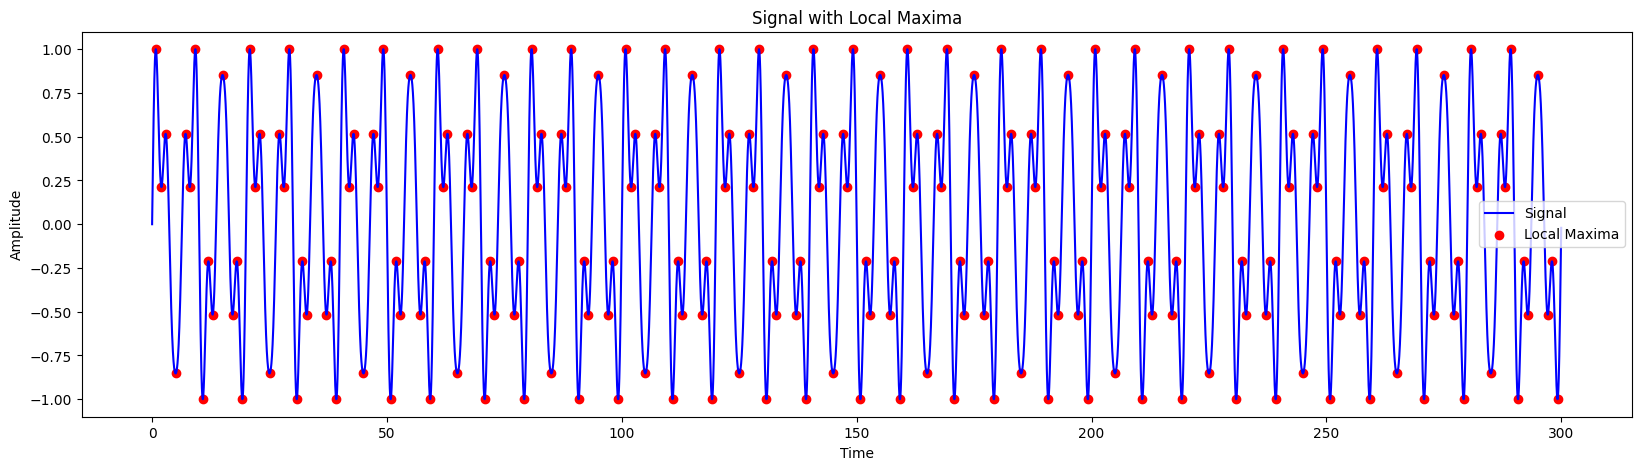

In [20]:
def find_peaks(signal):
    local_maxima = signal[(signal.shift(1) < signal) & (signal.shift(-1) < signal)]
    local_minima = signal[(signal.shift(1) > signal) & (signal.shift(-1) > signal)]
    peaks = pd.concat([local_maxima, local_minima]).sort_index()
    return peaks

peaks = find_peaks(signal)

plt.figure(figsize = (20, 5))
plt.plot(signal, label = 'Signal', color = 'blue')
plt.scatter(peaks.index, peaks.values, color = 'red', label = 'Local Maxima')
plt.title('Signal with Local Maxima')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

plt.show()

In [27]:


HRV_peaks = peaks
PEAK_PSD = SincPsd.signal_to_PSD(peaks)
resampled_HRV_peaks = SincPsd.window(SincPsd.sinc_interpolate(HRV_peaks))
resampled_psd_peaks = SincPsd.sinc_and_psd(resampled_HRV_peaks)


plotter = SignalPsdPlotter("HRV signal and PSD simulated by maxima and minima sampling")

plotter.plot_signal_and_psd(HRV_peaks, resampled_psd_peaks, 'HRV Peaks', 'red')
plotter.plot_signal_and_psd(resampled_HRV_peaks, resampled_psd_peaks, 'Resampled HRV Peaks', 'blue')

plotter.show()


{window_type} window applied over:
left: index 0 to 5
right: index 203 to 210
